In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
datdir = "/Users/aewsma/Google Drive/research/ciam_v1.x/data/goodMonteCarlo1000runs_withRegions"

## Read Monte Carlo simulation results

### 5th, 50th and 95th percentiles only (single simulations)

In [3]:
df05 = pd.read_csv(datdir+"/globalnpv_SSP5_BRICK85_p05.csv")
df50 = pd.read_csv(datdir+"/globalnpv_SSP5_BRICK85_p50.csv")
df95 = pd.read_csv(datdir+"/globalnpv_SSP5_BRICK85_p95.csv")

In [4]:
df05r = pd.read_csv(datdir+"/regionnpv_SSP5_BRICK85_p05.csv")
df50r = pd.read_csv(datdir+"/regionnpv_SSP5_BRICK85_p50.csv")
df95r = pd.read_csv(datdir+"/regionnpv_SSP5_BRICK85_p95.csv")
regions = df05r.columns

In [5]:
df05 = df05.join(df05r)
df50 = df50.join(df50r)
df95 = df95.join(df95r)

### SLR uncertainty only

In [6]:
dfS = pd.read_csv(datdir+"/globalnpv_SSP5_BRICK85_varyBRICK.csv")
dfS = dfS.join(pd.read_csv(datdir+"/regionnpv_SSP5_BRICK85_varyBRICK.csv"))

### CIAM socioeconomic parameter uncertainty only

In [7]:
dfC = pd.read_csv(datdir+"/globalnpv_SSP5_BRICK85_varyCIAM.csv")
dfC = dfC.join(pd.read_csv(datdir+"/regionnpv_SSP5_BRICK85_varyCIAM.csv"))

### Both SLR and CIAM uncertainty

In [8]:
dfSC = pd.read_csv(datdir+"/globalnpv_SSP5_BRICK85_varySLR_varyCIAM.csv")
dfSC = dfSC.join(pd.read_csv(datdir+"/regionnpv_SSP5_BRICK85_varySLR_varyCIAM.csv"))

### Histogram

KDE version

In [9]:
kde = {}
kde["S"] = stats.gaussian_kde(dfS.npv)
kde["C"] = stats.gaussian_kde(dfC.npv)
kde["SC"] = stats.gaussian_kde(dfSC.npv)

x = np.linspace(0,12000,500)
kde_plot = {}
for k in kde.keys():
    kde_plot[k] = kde[k](x)

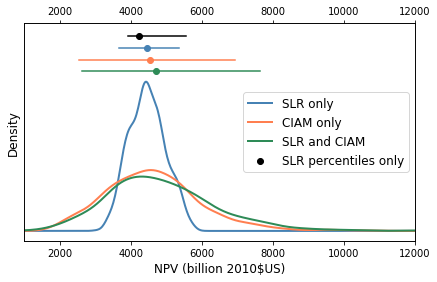

In [10]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
plt.plot(x,kde_plot["S"], linewidth=2, color="steelblue", label="SLR only")
plt.plot(x,kde_plot["C"], linewidth=2, color="coral", label="CIAM only")
plt.plot(x,kde_plot["SC"], linewidth=2, color="seagreen", label="SLR and CIAM")
y0 = 0.001; dy = 0.00006
plt.plot([df05.npv, df95.npv], [y0, y0], color="black"); plt.scatter(df50.npv, y0, color="black", label="SLR percentiles only")
y0 -= dy
plt.plot([dfS.npv.quantile(0.05), dfS.npv.quantile(0.95)], [y0, y0], color="steelblue"); plt.scatter(dfS.npv.median(), y0, color="steelblue")
y0 -= dy
plt.plot([dfC.npv.quantile(0.05), dfC.npv.quantile(0.95)], [y0, y0], color="coral"); plt.scatter(dfC.npv.median(), y0, color="coral")
y0 -= dy
plt.plot([dfSC.npv.quantile(0.05), dfSC.npv.quantile(0.95)], [y0, y0], color="seagreen"); plt.scatter(dfSC.npv.median(), y0, color="seagreen")
plt.xlabel("NPV (billion 2010$US)", fontsize=12); plt.ylabel("Density", fontsize=12); plt.yticks([])
plt.xlim([1000,12000])
plt.legend(fontsize=12, frameon=True)
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim());

Histogram version

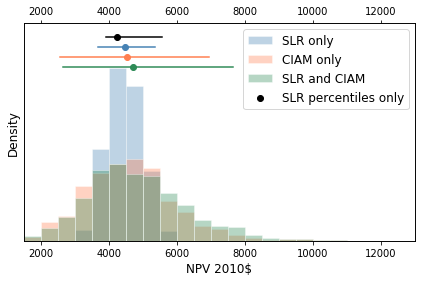

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
plt.hist(dfS.npv, edgecolor="white", color="steelblue", alpha=0.35, bins=range(1500,12000,500), density=True, label="SLR only")
plt.hist(dfC.npv, edgecolor="white", color="coral", alpha=0.35, bins=range(1500,12000,500), density=True, label="CIAM only")
plt.hist(dfSC.npv, edgecolor="white", color="seagreen", alpha=0.35, bins=range(1500,12000,500), density=True, label="SLR and CIAM")
y0 = 0.0008
plt.plot([df05.npv, df95.npv], [y0, y0], color="black"); plt.scatter(df50.npv, y0, color="black", label="SLR percentiles only")
y0 = 0.00076
plt.plot([dfS.npv.quantile(0.05), dfS.npv.quantile(0.95)], [y0, y0], color="steelblue"); plt.scatter(dfS.npv.median(), y0, color="steelblue")
y0 = 0.00072
plt.plot([dfC.npv.quantile(0.05), dfC.npv.quantile(0.95)], [y0, y0], color="coral"); plt.scatter(dfC.npv.median(), y0, color="coral")
y0 = 0.00068
plt.plot([dfSC.npv.quantile(0.05), dfSC.npv.quantile(0.95)], [y0, y0], color="seagreen"); plt.scatter(dfSC.npv.median(), y0, color="seagreen")
plt.xlabel("NPV 2010$", fontsize=12); plt.ylabel("Density", fontsize=12); plt.yticks([])
plt.xlim([1500,13000])
plt.legend(fontsize=12)
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim());

## aggregate by World Bank region (7 of them) and compute total NPV as %GDP (2010)

### GDP per capita

Grabbing just the first year (2010). All in US$2010.

In [11]:
ypcc = pd.read_csv("CIAM-Work/original_from_CL/code/ciam-code/data/ssp/ypcc_IIASAGDP_SSP5_v9_130219.csv")
dfGP = pd.DataFrame()
dfGP["rgn"] = ypcc.columns[1:]
dfGP["gdp_per_capita"] = np.array(ypcc.iloc[0][1:])

### population (millions)

In [12]:
pop = pd.read_csv("CIAM-Work/original_from_CL/code/ciam-code/data/ssp/pop_IIASAGDP_SSP5_v9_130219.csv")
dfGP["pop"] = np.array(pop.iloc[0][1:])

### get total GDP

In [13]:
dfGP["gdp"] = dfGP["gdp_per_capita"]*dfGP["pop"]*1e6/1e9 
# 1e6 since population is in units of millions
# and /1e9 to get in units of billions US$2010

### mapping of segments/regions in CIAM, to the 7 World Bank regions

gdp is in units of billions US$2010, since hte NPV results are also billions

In [14]:
wbsegs = pd.read_csv("segments_regions_WB.csv")
rgn_gdp = {}
for rgn in regions:
    rgns_this_rgn = wbsegs.loc[wbsegs["global region"]==rgn, "regions"].unique()
    rgn_gdp[rgn] = dfGP.loc[dfGP["rgn"].isin(rgns_this_rgn),"gdp"].sum()

In [15]:
print(rgn_gdp)

{'Europe and Central Asia': 18966.976402719152, 'Middle East and North Africa': 3938.501973598944, 'Sub-Saharan Africa': 1362.4469249975007, 'Latin America and the Caribbean': 6594.935674050595, 'East Asia and Pacific': 23439.597988189, 'South Asia': 5258.98316979206, 'North America': 15789.464594560679}


### compute the NPV as %GDP (in 2010)

In [16]:
for rgn in regions:
    dfS["npv/gpd "+rgn] = 100*dfS[rgn]/rgn_gdp[rgn]
    dfC["npv/gpd "+rgn] = 100*dfC[rgn]/rgn_gdp[rgn]
    dfSC["npv/gpd "+rgn] = 100*dfSC[rgn]/rgn_gdp[rgn]

world NPV as %GDP

In [17]:
dfS["npv/gpd"] = 100*dfS["npv"]/np.sum(list(rgn_gdp.values()))
dfC["npv/gpd"] = 100*dfC["npv"]/np.sum(list(rgn_gdp.values()))
dfSC["npv/gpd"] = 100*dfSC["npv"]/np.sum(list(rgn_gdp.values()))

<br>

# histograms for each region

<br>

KDE version

In [18]:
kde = {}
kde["S"] = {}; kde["C"] = {}; kde["SC"] = {}
kde["S"]["World"] = stats.gaussian_kde(dfS["npv/gpd"])
kde["C"]["World"] = stats.gaussian_kde(dfC["npv/gpd"])
kde["SC"]["World"] = stats.gaussian_kde(dfSC["npv/gpd"])
for rgn in regions:
    kde["S"][rgn] = stats.gaussian_kde(dfS["npv/gpd "+rgn])
    kde["C"][rgn] = stats.gaussian_kde(dfC["npv/gpd "+rgn])
    kde["SC"][rgn] = stats.gaussian_kde(dfSC["npv/gpd "+rgn])
    
x = np.linspace(0,15,200)
kde_plot = {}
kde_plot["S"] = {}; kde_plot["C"] = {}; kde_plot["SC"] = {}
kde_plot["S"]["World"] = kde["S"]["World"](x)
kde_plot["C"]["World"] = kde["C"]["World"](x)
kde_plot["SC"]["World"] = kde["SC"]["World"](x)
for rgn in regions:
    kde_plot["S"][rgn] = kde["S"][rgn](x)
    kde_plot["C"][rgn] = kde["C"][rgn](x)
    kde_plot["SC"][rgn] = kde["SC"][rgn](x)

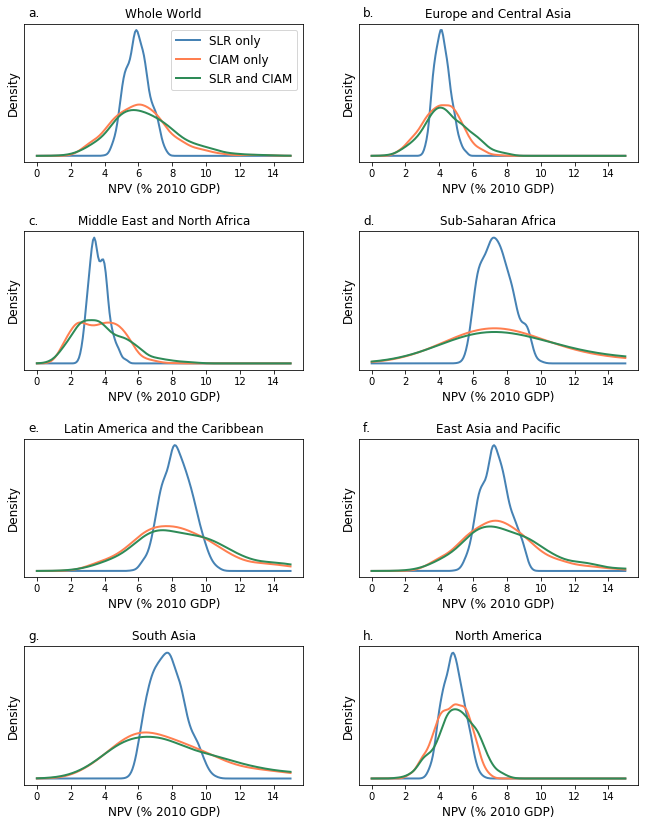

In [19]:
# from above

fig, ax = plt.subplots(4,2,figsize=(11,14))
fig.subplots_adjust(hspace=.5)
bins = range(0,20,1)
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]

# whole world
rgn = "World"
pan = 0
ax[0][0].plot(x, kde_plot["S"][rgn], linewidth=2, color="steelblue", label="SLR only")
ax[0][0].plot(x, kde_plot["C"][rgn], linewidth=2, color="coral", label="CIAM only")
ax[0][0].plot(x, kde_plot["SC"][rgn], linewidth=2, color="seagreen", label="SLR and CIAM")
ax[0][0].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
ax[0][0].set_ylabel("Density", fontsize=12); ax[0][0].set_yticks([])
ax[0][0].legend(fontsize=12, frameon=True)
ax[0][0].set_title("Whole World")
#ylims = ax[0][0].get_ylim(); top = ylims[1]+.05*(ylims[1]-ylims[0]); ax[0][0].text(-0.5,top,"a.", fontsize=12)
ylims = ax[0][0].get_ylim(); top = ylims[1]*1.05; ax[0][0].text(-0.5,top, panels[pan], fontsize=12);

# regions
rgn = regions[0]
pan += 1
ax[0][1].plot(x, kde_plot["S"][rgn], linewidth=2, color="steelblue", label="SLR only")
ax[0][1].plot(x, kde_plot["C"][rgn], linewidth=2, color="coral", label="CIAM only")
ax[0][1].plot(x, kde_plot["SC"][rgn], linewidth=2, color="seagreen", label="SLR and CIAM")
ax[0][1].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
ax[0][1].set_ylabel("Density", fontsize=12); ax[0][1].set_yticks([])
ax[0][1].set_title(rgn)
ylims = ax[0][1].get_ylim(); top = ylims[1]*1.05; ax[0][1].text(-0.5,top, panels[pan], fontsize=12);

ir = 1
for row in range(1,4):
    for col in range(2):
        rgn = regions[ir]
        ir += 1
        pan += 1
        ax[row][col].plot(x, kde_plot["S"][rgn], linewidth=2, color="steelblue", label="SLR only")
        ax[row][col].plot(x, kde_plot["C"][rgn], linewidth=2, color="coral", label="CIAM only")
        ax[row][col].plot(x, kde_plot["SC"][rgn], linewidth=2, color="seagreen", label="SLR and CIAM")
        ax[row][col].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
        ax[row][col].set_ylabel("Density", fontsize=12); ax[row][col].set_yticks([])
        ax[row][col].set_title(rgn)
        ylims = ax[row][col].get_ylim(); top = ylims[1]*1.05; ax[row][col].text(-0.5,top, panels[pan], fontsize=12);

Histogram version

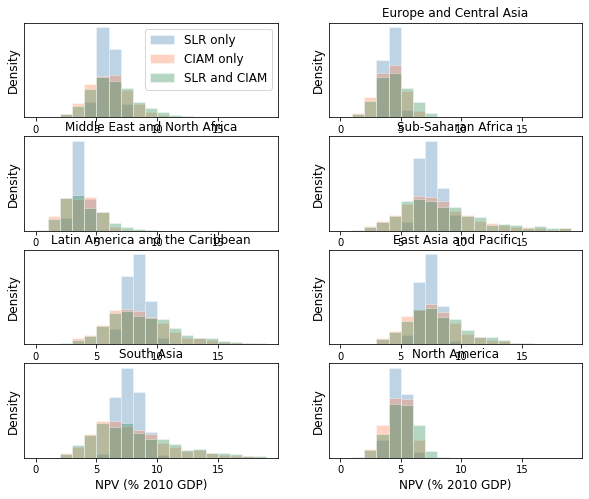

In [163]:
# from above

fig, ax = plt.subplots(4,2,figsize=(10,8))
bins = range(0,20,1)

# whole world
ax[0][0].hist(dfS["npv/gpd"], edgecolor="white", color="steelblue", alpha=0.35, bins=bins, density=True, label="SLR only")
ax[0][0].hist(dfC["npv/gpd"], edgecolor="white", color="coral", alpha=0.35, bins=bins, density=True, label="CIAM only")
ax[0][0].hist(dfSC["npv/gpd"], edgecolor="white", color="seagreen", alpha=0.35, bins=bins, density=True, label="SLR and CIAM")
ax[0][0].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
ax[0][0].set_ylabel("Density", fontsize=12); ax[0][0].set_yticks([])
ax[0][0].legend(fontsize=12)
ax[0][1].set_title("Whole World");

# regions
rgn = regions[0]
ax[0][1].hist(dfS["npv/gpd "+rgn], edgecolor="white", color="steelblue", alpha=0.35, bins=bins, density=True, label="SLR only")
ax[0][1].hist(dfC["npv/gpd "+rgn], edgecolor="white", color="coral", alpha=0.35, bins=bins, density=True, label="CIAM only")
ax[0][1].hist(dfSC["npv/gpd "+rgn], edgecolor="white", color="seagreen", alpha=0.35, bins=bins, density=True, label="SLR and CIAM")
ax[0][1].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
ax[0][1].set_ylabel("Density", fontsize=12); ax[0][1].set_yticks([])
ax[0][1].set_title(rgn);

ir = 1
for row in range(1,4):
    for col in range(2):
        rgn = regions[ir]
        ir += 1
        ax[row][col].hist(dfS["npv/gpd "+rgn], edgecolor="white", color="steelblue", alpha=0.35, bins=bins, density=True, label="SLR only")
        ax[row][col].hist(dfC["npv/gpd "+rgn], edgecolor="white", color="coral", alpha=0.35, bins=bins, density=True, label="CIAM only")
        ax[row][col].hist(dfSC["npv/gpd "+rgn], edgecolor="white", color="seagreen", alpha=0.35, bins=bins, density=True, label="SLR and CIAM")
        ax[row][col].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
        ax[row][col].set_ylabel("Density", fontsize=12); ax[row][col].set_yticks([])
        ax[row][col].set_title(rgn);

## Check quantiles as sample size changes

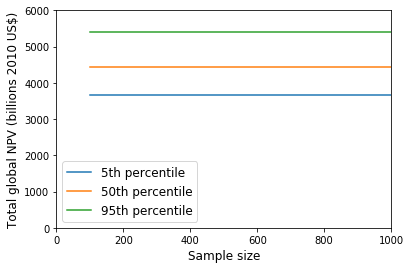

In [116]:
sample_sizes = np.arange(start=100,stop=1100,step=100)
quantiles = np.zeros((len(sample_sizes),3))
for ii in range(len(sample_sizes)):
    quantiles[ii,0] = dfS[:sample_sizes[ii]]["npv"].quantile(.05)
    quantiles[ii,1] = dfS[:sample_sizes[ii]]["npv"].quantile(.5)
    quantiles[ii,2] = dfS[:sample_sizes[ii]]["npv"].quantile(.95)

plt.plot(sample_sizes, quantiles[:,0], label="5th percentile")
plt.plot(sample_sizes, quantiles[:,1], label="50th percentile")
plt.plot(sample_sizes, quantiles[:,2], label="95th percentile")
plt.xlim([0,1000]); plt.ylim([0,6000])
plt.xlabel("Sample size", fontsize=12); plt.ylabel("Total global NPV (billions 2010 US$)", fontsize=12)
plt.legend(loc="best", fontsize=12);